# Validation Execution

In [1]:
import papermill as pm
import pandas as pd
import plotnine as pn
from collections import OrderedDict
import os
import json
from tqdm import tqdm, TqdmSynchronisationWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)
nb_dir = 'results'

c:\users\user\anaconda3\envs\codex\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Deconvolution

In [3]:
args = OrderedDict()

# Crop slices (@25%):
# 128 - 48:80 (n=32)
# 256 - 96:160 (n=64)
# 512 - 192:320 (n=128)
# WARNING: Make sure that crop slices are centered or PSFs will not 
# be symmetric and lead to nonsense results

# Bars (Orig: 128x256x256)
args['bars-samp'] = dict(
    downsample_factor=.25,
    n_iter=25, dataset_name='bars'
)
args['bars-crop'] = dict(
    crop_slice='(slice(48, 80), slice(96, 160), slice(96, 160))', 
    n_iter=25, dataset_name='bars'
)

# Microtubules (Orig: 128x256x512)
args['microtubules-samp'] = dict(
    downsample_factor=.25, 
    dataset_name='microtubules', n_iter=25
)
args['microtubules-crop'] = dict(
    crop_slice='(slice(48, 80), slice(96, 160), slice(192, 320))',
    dataset_name='microtubules', n_iter=25
)

# Bead (256, 256, 256)
args['bead-samp'] = dict(n_iter=25, downsample_factor=.25, dataset_name='bead')

# CElegans (Orig: 104x712x672)
args['celegans-dapi-crop'] = dict(
    n_iter=25, 
    # Crop slice to truncate signals at borders as a test of edge artifacts
    crop_slice='(slice(36, 68), slice(228, 484), slice(208, 464))', 
    dataset_name='celegans-dapi'
) 

out_dir = os.path.join(nb_dir, 'deconvolution')
os.makedirs(out_dir, exist_ok=True)
for k, params in args.items():
    print('Processing dataset', k)
    out_path = os.path.join(out_dir, k + '.ipynb')
    pm.execute_notebook('deconvolution.ipynb', out_path, parameters=params)

Processing dataset bars-samp


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\bars-samp.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:37<00:00,  1.38s/it]


Processing dataset bars-crop


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\bars-crop.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:37<00:00,  1.38s/it]


Processing dataset microtubules-samp


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\microtubules-samp.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.58s/it]


Processing dataset microtubules-crop


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\microtubules-crop.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:41<00:00,  1.53s/it]


Processing dataset bead-samp


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\bead-samp.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:42<00:00,  1.56s/it]


Processing dataset celegans-dapi-crop


Input Notebook:  deconvolution.ipynb
Output Notebook: results\deconvolution\celegans-dapi-crop.ipynb
100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:58<00:00,  4.38s/it]


In [41]:
df = pm.read_notebooks(out_dir).dataframe
df.head()

,name,value,type,filename,key
0,crop_slice,"(slice(48, 80), slice(96, 160), slice(96, 160))",parameter,bars-crop.ipynb,bars-crop.ipynb
1,dataset_name,bars,parameter,bars-crop.ipynb,bars-crop.ipynb
2,n_iter,25,parameter,bars-crop.ipynb,bars-crop.ipynb
3,scores,"[{""lib"":""dl2"",""algo"":""lw"",""nrmse"":-1.842583111...",record,bars-crop.ipynb,bars-crop.ipynb
4,dataset_name,bars,parameter,bars-samp.ipynb,bars-samp.ipynb


In [42]:
scores = []
for k, g in df.groupby('key'):
    dataset = k.replace('.ipynb', '')
    json_df = g.set_index('name').loc['scores']['value']
    scores.append(pd.DataFrame.from_records(json.loads(json_df)).assign(dataset=dataset))
scores = pd.concat(scores)
scores.head()

,algo,comp_type,lib,nrmse,psnr,ssim,dataset
0,lw,ground_truth,dl2,-1.842583,7.551699,0.116184,bars-crop
1,nif,ground_truth,dl2,-2.997178,3.325989,0.021215,bars-crop
2,rif,ground_truth,dl2,-1.870676,7.420269,0.131307,bars-crop
3,rl-npad,ground_truth,dl2,-1.406720,9.896085,0.203789,bars-crop
4,rl-wpad,ground_truth,dl2,-1.514692,9.253757,0.187872,bars-crop


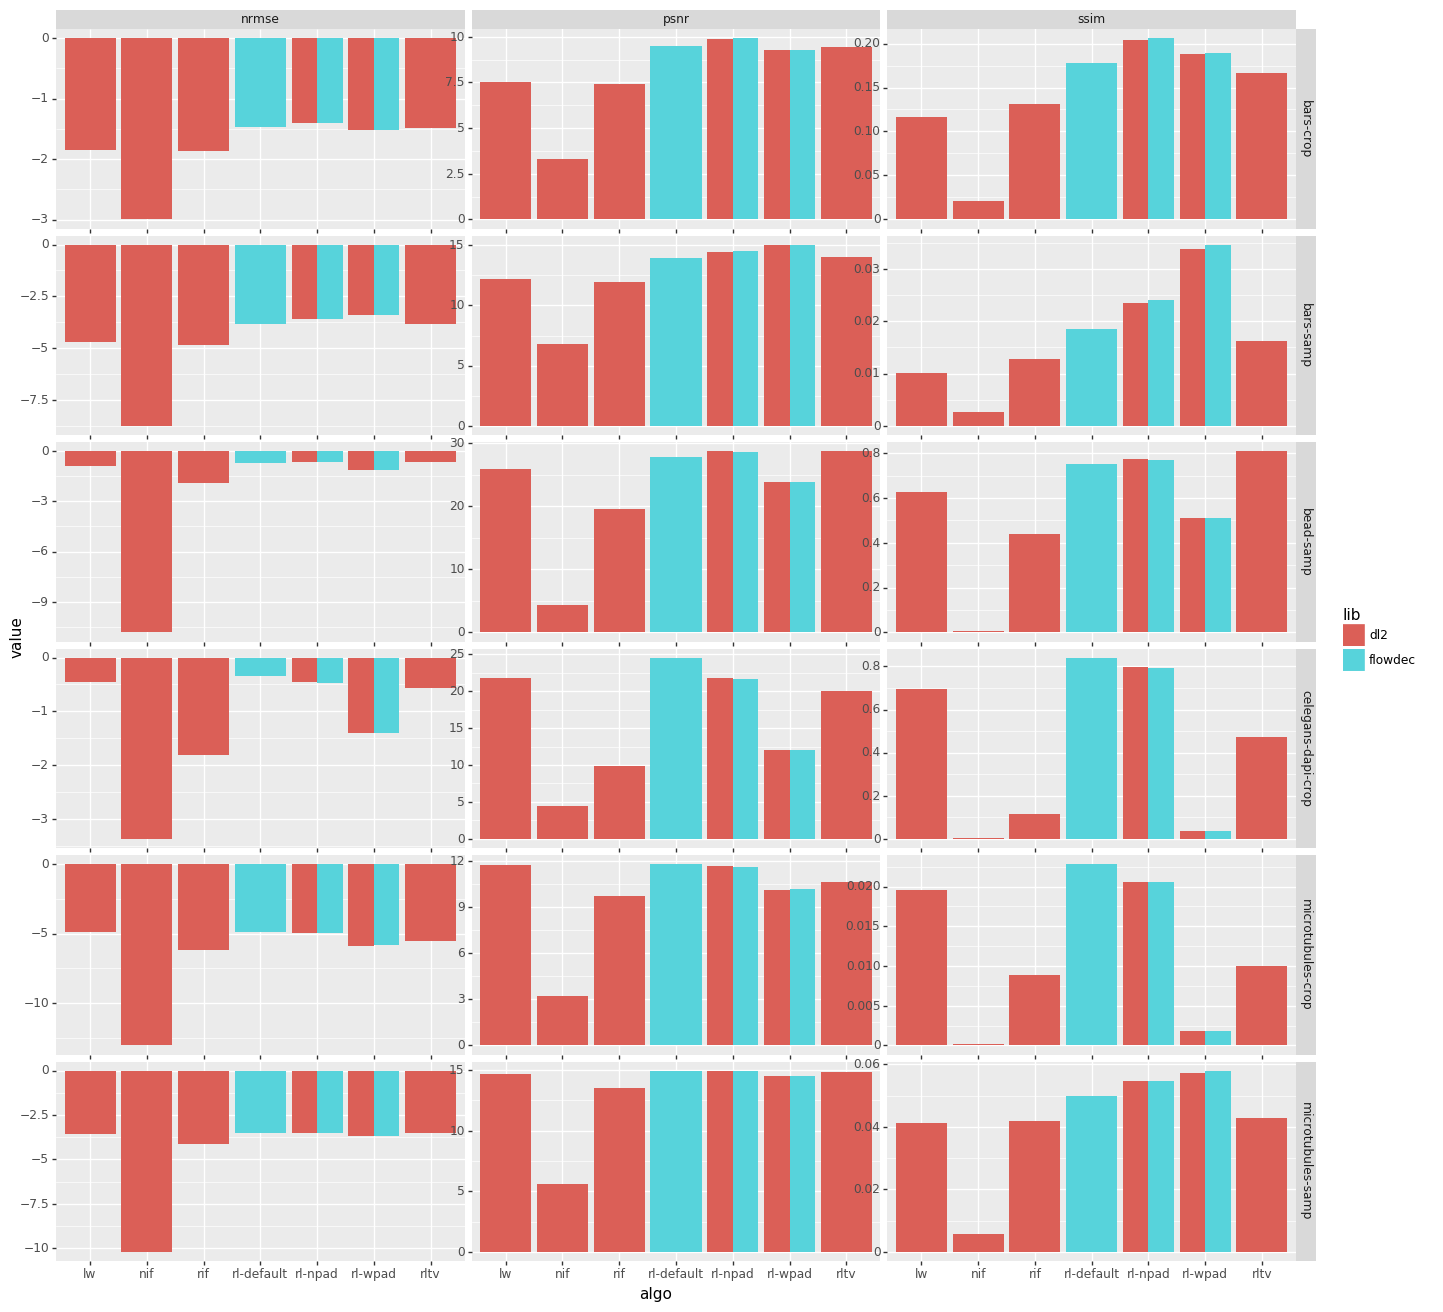

<ggplot: (-9223371958826418635)>

In [6]:
(
    pn.ggplot(
        scores.melt(id_vars=['algo', 'lib', 'comp_type', 'dataset']), 
        pn.aes(x='algo', y='value', fill='lib')
    ) +
    pn.geom_bar(stat='identity', position='dodge') +
    pn.facet_grid('dataset~variable', scales='free') +
    pn.theme(figure_size=(16, 16))
)

In [38]:
def plot_scores(df, algo, sort_metric, title):
    df = df[df['algo'] == algo].drop('algo', axis=1)
    order = df.groupby('dataset')[sort_metric].mean().sort_values().index
    df = df.melt(id_vars=['lib', 'comp_type', 'dataset'])
    df['dataset'] = pd.Categorical(df['dataset'], ordered=True, categories=order)
    
    return (
        pn.ggplot(df, pn.aes(x='dataset', y='value', fill='lib')) +
        pn.geom_bar(stat='identity', position='dodge') +
        pn.facet_wrap('~variable', scales='free', ncol=1) +
        pn.ggtitle(title) +
        pn.scale_fill_brewer(type='qual', palette='Set1', guide=pn.guide_legend(title='Library')) +
        pn.xlab('Dataset Name') +
        pn.ylab('Score Value (higher is better)') +
        pn.theme(figure_size=(12, 8))
    )

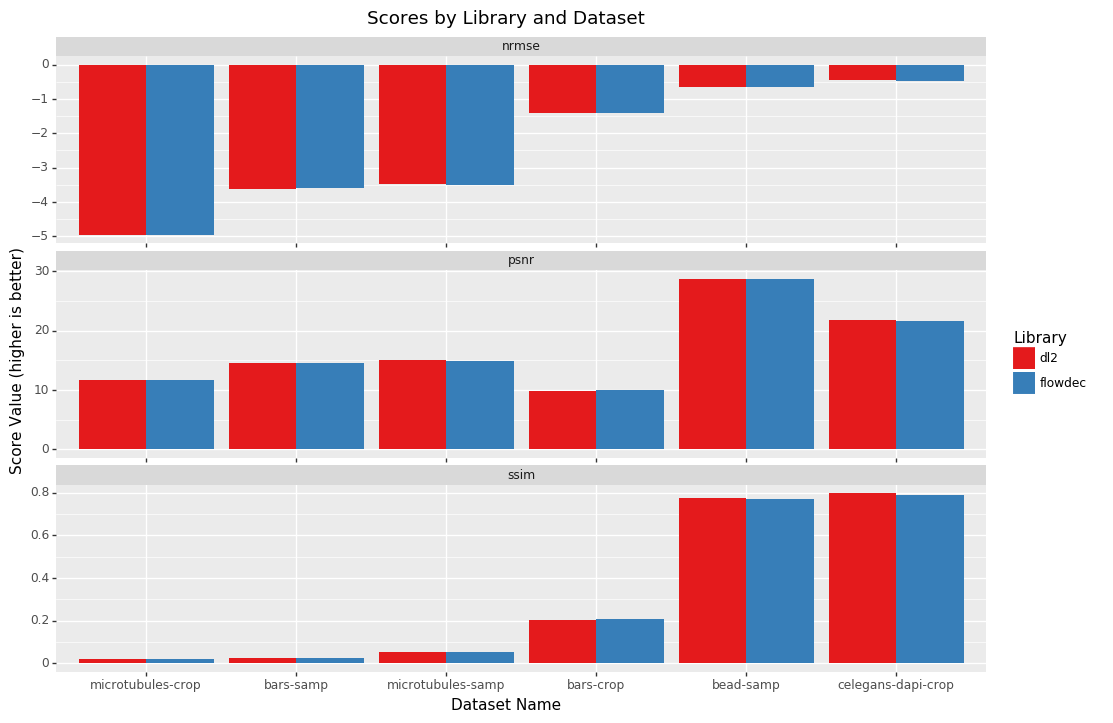

<ggplot: (78030769023)>

In [43]:
plot_scores(scores, 'rl-npad', 'ssim', 'Scores by Library and Dataset')